In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

from tqdm import tqdm

# import TextController

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TEST_INPUT_DATA = 'test_input.npy'
TEST_LABEL_DATA = 'test_label.npy'
SAVE_FILE_NM = 'weights.h5'
DATA_CONFIGS = 'data_configs.json'

trainInputs = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
trainInputs = pad_sequences(trainInputs, maxlen=trainInputs.shape[1])
trainLabel = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
preproConfigs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# print(trainInputs)
# print(preproConfigs)

In [3]:
modelName = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 2
VALID_SPLIT = 0.1
MAX_LEN = trainInputs.shape[1]

kargs = {'model_name':modelName,
        'vocab_size':preproConfigs['vocab_size'],
        'embedding_size':128,
        'num_filters':100,
        'dropout_rate':0.5,
        'hidden_dimension':250,
        'output_dimension':1}

In [4]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                       kernel_size=kernel_size,
                                       padding='valid',
                                       activation = tf.keras.activations.relu,
                                       kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPool1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                               activation=tf.keras.activations.relu,
                               kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation=tf.keras.activations.sigmoid,
                                kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [5]:
model = CNNClassifier(**kargs)
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy')])


In [6]:
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = DATA_OUT_PATH + '/' + modelName + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print('경로 있음')
else:    
    os.makedirs(checkpoint_dir, exist_ok=True)
    print('경로 생성')
    
cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(trainInputs, trainLabel, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_split=VALID_SPLIT, 
                    callbacks=[earlystop_callback, cp_callback])

경로 있음
Epoch 1/2
46/46 [==============================] - 32s 657ms/step - loss: -7.3233 - accuracy: 0.9095 - val_loss: -32.2293 - val_accuracy: 0.9300

Epoch 00001: val_accuracy improved from -inf to 0.93003, saving model to ./data_out/cnn_classifier_kr/weights.h5
Epoch 2/2
46/46 [==============================] - 30s 652ms/step - loss: -296.0209 - accuracy: 0.9301 - val_loss: -811.7693 - val_accuracy: 0.9300

Epoch 00002: val_accuracy did not improve from 0.93003


In [7]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

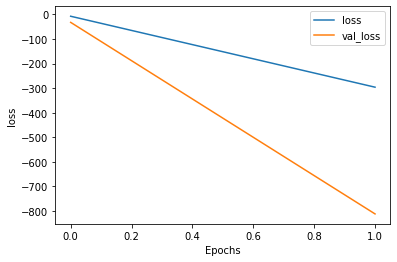

In [8]:
plot_graphs(history, 'loss')

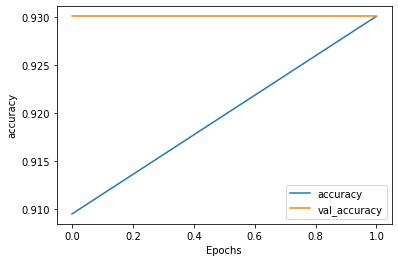

In [9]:
plot_graphs(history, 'accuracy')

In [10]:
testInput = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
testInput = pad_sequences(testInput, maxlen=testInput.shape[1])
testLabelData = np.load(open(DATA_IN_PATH + TEST_LABEL_DATA, 'rb'))

model.load_weights(os.path.join(DATA_OUT_PATH, modelName, SAVE_FILE_NM))
# model.evaluate(testInput, testLabelData)
# model.fit(train_images, train_labels, epochs=5)

# model.evaluate(testInput.iloc[3], testLabelData.iloc[3])

In [11]:
# model.evaluate(testInput[3], testLabelData[3])
print(testInput[3])
# model.predict(testInput[3])

[  849    69   124   205    75    92    99   256    16  1108     7  1050
     8    71     1   592   335  1182    76    81    18   105   971    11
    36   107    92    99   256  1484  1108  2895     6    71     1    92
    99   256   390     7    92   352  1572  1108  2766   899  1034     6
    71     1    17  5971  2038  2145    16  2293    16  2298 36492   113
   154   656    53    22    15     1     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [12]:
print(trainInputs)

[[  403     7   237 ...  6678    28     1]
 [  364   209  1852 ...     1   133     1]
 [  979   862   870 ...     0     0     0]
 ...
 [ 2129  1755 17005 ...     0     0     0]
 [  281   247    77 ...   943   155    72]
 [   41     6   255 ...     0     0     0]]


In [38]:
from sklearn.metrics import accuracy_score


print('야호')
#구매글

# token = textToToken('\uc544\ub514\ub2e4\uc2a4 \uc6b8\ud2b8\ub77c\ubd80\uc2a4\ud2b8 \uad6c\uc785\ud569\ub2c8\ub2e4.\n280 \uc0ac\uc774\uc988 \uc81c\ud488\uc73c\ub85c \uad6c\uc785\ud569\ub2c8\ub2e4\n\n\ucca8 \uc811\ud574\ubcf4\ub294 \uc6b8\ud2b8\ub77c\ubd80\uc2a4\ud2b8 \uc785\ub2c8\ub2e4\n\ud639\uc2dc \ubc29\uce58\uc911\uc778 \uc81c\ud488 \uc788\uc73c\uba74 \uad6c\uc785\ud569\ub2c8\ub2e4\n7-8\ub9cc\uc6d0 \uad6c\uc785 \uac00\ub2a5\ud569\ub2c8\ub2e4~^^"')


#판매글
token = textToToken('\uc544\uc774\ud3f0 se 1\uc138\ub300 32g \uc2a4\uadf8 (\ucee8\ud2b8\ub9ac\ub77d, \uce74\uba54\ub77c \ubb34\uc74c)\n\n\ucd5c\uc2e0 \ud5e4\uc774\uc2ec \ud3ec\ud568\ud574\uc11c \ub4dc\ub9bd\ub2c8\ub2e4. \uc624\ub298\uae4c\uc9c0\ub3c4 \ud65c\uc131\ud654 \ubb38\uc81c \uc5c6\ub124\uc694.\n\uc0ac\uc6a9\ubc95 \uc544\uc2dc\ub294\ubd84\uc774 \uad6c\ub9e4\ud558\uc168\uc73c\uba74 \uc88b\uaca0\uc2b5\ub2c8\ub2e4.\n\ubc30\ud130\ub9ac \uc131\ub2a5 87%, \ub4e4\ub738 \uc5c6\uc74c, \uc9c0\ubb38\uc778\uc2dd \uc591\ud638, \uc0ac\uc124\uc218\ub9ac\uc774\ub825 \uc5c6\uc74c\n\ube48\ubc15\uc2a4, sword pro \uc54c\ub8e8\ubbf8\ub284 \ubc94\ud37c, \ud22c\uba85\ucf00\uc774\uc2a4, \uc561\ubcf4 3\uc7a5 \uad6c\uc131\n\n\ubb34\ubcf4\uc815 \uc0c1\uc138\uc0ac\uc9c4\nhttps://www.dropbox.com/sh/ukafjbzyab5p13p/AADzOArcCDtRNoTKBnJ-6ffMa?dl=0')

 

# Y_pred = model.predict_classes(X_test)
# print(Y_pred)
# print('iiiiii')
# print(token)
# temp = np 
# print(np.array([testInput[0]]))
print('iiiiii')
# print(testLabelData[11])
# print(type(token))
# print(TextController.test())

# print('asd')

# tokenNpArray = np.asarray(token)
# print(tokenNpArray)
# print(testInput[2])
# print(token[0])
# prediction = model.predict(token)
# prediction = model.predict(np.array([testInput[11]]))
prediction = model.predict(np.array(testInput))
print(type(prediction))
print(prediction)
print(prediction[0:90])
print('ddd')
# data = request.get_json(force=True)
# prediction = model.predict([[np.array(data['exp'])]])
# output = prediction[0]



야호
아이폰 se 1세대 32g 스그 (컨트리락, 카메라 무음)

최신 헤이심 포함해서 드립니다. 오늘까지도 활성화 문제 없네요.
사용법 아시는분이 구매하셨으면 좋겠습니다.
배터리 성능 87%, 들뜸 없음, 지문인식 양호, 사설수리이력 없음
빈박스, sword pro 알루미늄 범퍼, 투명케이스, 액보 3장 구성

무보정 상세사진
https://www.dropbox.com/sh/ukafjbzyab5p13p/AADzOArcCDtRNoTKBnJ-6ffMa?dl=0
255
[0, 0, 315, 0, 69, 510, 0, 26, 682, 244, 0, 33, 20, 85, 0, 221, 166, 0, 0, 6216, 862, 1133, 3284, 0, 0, 2012, 3358, 216, 0, 382, 2319, 0, 0, 0, 1141, 1195, 0, 6620, 0, 1666, 0, 1292, 1379, 504, 167, 0, 2262, 7949, 155, 72, 0, 0, 556, 3598, 0, 186, 30, 0, 3045, 516, 448, 0, 722, 61, 0, 0, 110, 233, 0, 0, 79, 50, 7476, 0, 0, 36, 0, 77, 0, 0, 37, 281, 0, 25176, 7212, 62, 0, 29113, 0, 3611, 155, 72, 0, 0, 468, 1018, 1133, 0, 516, 7605, 0, 89, 124, 0, 0, 0, 0, 19713, 0, 0, 2319, 0, 0, 186, 722, 121, 652, 0, 944, 2145, 0, 0, 79, 3742, 0, 1133, 0, 2699, 0, 0, 2319, 0, 2373, 1728, 221, 0, 0, 69, 213, 388, 789, 557, 0, 578, 789, 388, 0, 800, 5120, 0, 0, 0, 33901, 2823, 0, 0, 1156, 291, 3812, 0, 221, 0, 0, 3410, 0, 0, 33, 147, 0, 37, 516

In [14]:
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer



DATA_IN_PATH = './data_in/'
DATA_CONFIGS = 'data_configs.json'

okt=Okt()
stopWords = ['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한']
preproConfigs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

#기존에 학습할떄 사용한 토큰용 사전을 입력한다
tokenizer = Tokenizer()
tokenizer.word_index = preproConfigs['vocab']



# In[30]:


def textToToken(text):
    print(text)
    tokenizerArray = tokenizer.texts_to_sequences(text)
    tempArray = []
#     tempArray2 = np.array([])
    for temp in tokenizerArray:
        if len(temp) == 1:
#             print(temp[0])
            tempArray.append(temp[0])
    
        else:
            tempArray.append(0)
    print(len(tempArray))            
    print(tempArray)
#     tempArray2 = np.array(tempArray, dtype=int)
#     tempArray2 = np.array(tempArray, dtype=str)
#     tempArray2 = np.array(tempArray)
#     print(tempArray2)
    trainInputs = pad_sequences([tempArray], maxlen=100, padding='post')
#     trainInputs = pad_sequences(trainSequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    return trainInputs

#구매글

token = textToToken('\uc544\ub514\ub2e4\uc2a4 \uc6b8\ud2b8\ub77c\ubd80\uc2a4\ud2b8 \uad6c\uc785\ud569\ub2c8\ub2e4.\n280 \uc0ac\uc774\uc988 \uc81c\ud488\uc73c\ub85c \uad6c\uc785\ud569\ub2c8\ub2e4\n\n\ucca8 \uc811\ud574\ubcf4\ub294 \uc6b8\ud2b8\ub77c\ubd80\uc2a4\ud2b8 \uc785\ub2c8\ub2e4\n\ud639\uc2dc \ubc29\uce58\uc911\uc778 \uc81c\ud488 \uc788\uc73c\uba74 \uad6c\uc785\ud569\ub2c8\ub2e4\n7-8\ub9cc\uc6d0 \uad6c\uc785 \uac00\ub2a5\ud569\ub2c8\ub2e4~^^"')

#판매 글
# token = textToToken('\uc544\uc774\ud3f0 se 1\uc138\ub300 32g \uc2a4\uadf8 (\ucee8\ud2b8\ub9ac\ub77d, \uce74\uba54\ub77c \ubb34\uc74c)\n\n\ucd5c\uc2e0 \ud5e4\uc774\uc2ec \ud3ec\ud568\ud574\uc11c \ub4dc\ub9bd\ub2c8\ub2e4. \uc624\ub298\uae4c\uc9c0\ub3c4 \ud65c\uc131\ud654 \ubb38\uc81c \uc5c6\ub124\uc694.\n\uc0ac\uc6a9\ubc95 \uc544\uc2dc\ub294\ubd84\uc774 \uad6c\ub9e4\ud558\uc168\uc73c\uba74 \uc88b\uaca0\uc2b5\ub2c8\ub2e4.\n\ubc30\ud130\ub9ac \uc131\ub2a5 87%, \ub4e4\ub738 \uc5c6\uc74c, \uc9c0\ubb38\uc778\uc2dd \uc591\ud638, \uc0ac\uc124\uc218\ub9ac\uc774\ub825 \uc5c6\uc74c\n\ube48\ubc15\uc2a4, sword pro \uc54c\ub8e8\ubbf8\ub284 \ubc94\ud37c, \ud22c\uba85\ucf00\uc774\uc2a4, \uc561\ubcf4 3\uc7a5 \uad6c\uc131\n\n\ubb34\ubcf4\uc815 \uc0c1\uc138\uc0ac\uc9c4\nhttps://www.dropbox.com/sh/ukafjbzyab5p13p/AADzOArcCDtRNoTKBnJ-6ffMa?dl=0')
print(token)

아디다스 울트라부스트 구입합니다.
280 사이즈 제품으로 구입합니다

첨 접해보는 울트라부스트 입니다
혹시 방치중인 제품 있으면 구입합니다
7-8만원 구입 가능합니다~^^"
96
[0, 826, 72, 221, 0, 1384, 862, 216, 602, 221, 862, 0, 37, 1456, 1563, 155, 72, 0, 0, 20, 89, 676, 0, 79, 0, 632, 0, 61, 129, 7212, 14, 0, 37, 1456, 1563, 155, 72, 0, 0, 8160, 0, 4853, 504, 0, 0, 0, 1384, 862, 216, 602, 221, 862, 0, 1456, 155, 72, 0, 1060, 36, 0, 1199, 1775, 93, 121, 0, 61, 129, 0, 0, 7212, 62, 0, 37, 1456, 1563, 155, 72, 0, 124, 0, 89, 47, 304, 0, 37, 1456, 0, 0, 7605, 1563, 155, 72, 0, 0, 0, 0]
[[   0  826   72  221    0 1384  862  216  602  221  862    0   37 1456
  1563  155   72    0    0   20   89  676    0   79    0  632    0   61
   129 7212   14    0   37 1456 1563  155   72    0    0 8160    0 4853
   504    0    0    0 1384  862  216  602  221  862    0 1456  155   72
     0 1060   36    0 1199 1775   93  121    0   61  129    0    0 7212
    62    0   37 1456 1563  155   72    0  124    0   89   47  304    0
    37 1456    0    0 7605 1563  155   72    0    0